In [2]:
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from glob import glob
import torch
from tqdm import tqdm
import os
import torch
import numpy as np
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from collections import Counter

## Define some function

In [3]:
# Some metrics
def cosine_similarity(vector1, vector2):
    # Tính cosine similarity sau khi chuẩn hóa vector
    return np.dot(vector1 / np.linalg.norm(vector1), vector2 / np.linalg.norm(vector2))

def mean_squared_error(vector1, vector2):
    # Tính mean squared error
    return np.mean((vector1 - vector2) ** 2)

def load_model_and_feature_extractor(config):
    # Tạo và tải mô hình từ pre-trained checkpoint
    model = AutoModelForImageClassification.from_pretrained(config.pretrain_name).to(config.device).eval()

    # Tạo feature extractor từ pre-trained checkpoint
    feature_extractor = AutoFeatureExtractor.from_pretrained(config.pretrain_name, do_resize=config.do_resize)

    return model, feature_extractor


In [4]:
class Config:
    def __init__(self):
        # Định nghĩa các thuộc tính cấu hình
        self.pretrain_name = "/kaggle/input/lab05-pretrained/trained_models/checkpoint-1140"  # Tên checkpoint pre-trained
        self.do_resize = False  # Có thay đổi kích thước ảnh đầu vào hay không
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Thiết bị sử dụng (cuda hoặc cpu)
        self.path_train = "/kaggle/input/lab05-data/dataset/data_new_class/train/"  # Đường dẫn đến dữ liệu huấn luyện
        self.class_new = [i.split('/')[-1] for i in glob("/kaggle/input/lab05-data/dataset/data_new_class/test/*")]  # Danh sách các lớp mới
        self.all_folder = glob("/kaggle/input/lab05-data/dataset/few_shot_reference/*")  # Đường dẫn đến thư mục chứa dữ liệu tham chiếu
        self.batch_size = 64
        self.top_k = 5

def wrapper_features_embedding(config, feature_extractor, base_model, batch_img):
    # Chuyển batch ảnh thành dạng PyTorch tensor và di chuyển vào GPU (nếu có)
    inputs = feature_extractor(images=batch_img, return_tensors="pt").to(config.device)

    with torch.no_grad():
        # Gọi mô hình và lấy feature embedding
        feature_embedding = base_model.beit(**inputs).last_hidden_state

        # Chuyển feature embedding thành numpy array
        return feature_embedding.view((len(batch_img), -1)).cpu().numpy()


def load_reference_embeddings(config, feature_extractor, model):
    ref_path = []
    ref_classes = []

    # Duyệt qua tất cả các thư mục trong thư mục tham chiếu
    for folder in config.all_folder:
        class_name = folder.split("/")[-1]  # Lấy tên lớp từ tên thư mục
        if class_name in config.class_new:  # Kiểm tra xem lớp có trong danh sách lớp mới hay không
            # Duyệt qua tất cả các tệp trong thư mục tham chiếu
            for file in glob(f"{folder}/*"):
                ref_classes.append(class_name)  # Thêm tên lớp vào danh sách lớp tham chiếu
                ref_path.append(file)  # Thêm đường dẫn tệp vào danh sách đường dẫn tham chiếu

    # Tải các hình ảnh tham chiếu vào một danh sách
    batch_img = [Image.open(path) for path in ref_path]
    # Trích xuất các đặc trưng từ hình ảnh tham chiếu
    ref_embeddings = wrapper_features_embedding(config, feature_extractor, model, batch_img)
    return ref_embeddings, ref_classes

def find_most_common_class(data):
    class_counts = Counter(class_name for _, class_name in data)
    most_common_class = class_counts.most_common(1)[0][0]

    max_count = class_counts[most_common_class]
    most_common_classes = [class_name for class_name, count in class_counts.items() if count == max_count]

    if len(most_common_classes) > 1:
        highest_score = float('-inf')
        for class_name in most_common_classes:
            score = max(score for score, cn in data if cn == class_name)
            if score > highest_score:
                highest_score = score
                most_common_class = class_name

    return most_common_class

def predict_class(embedding , ref_embedding, ref_classes, top_k = 5):
    list_similarity = [cosine_similarity(embedding, i) for i in ref_embedding]
    output = list(zip(list_similarity, ref_classes))
    data =  sorted(output, key=lambda x: x[0], reverse = True)[:top_k]
    return find_most_common_class(data)


def create_image_batches(image_list, batch_size):
    image_batches = []  # Danh sách chứa các batch ảnh

    for i in range(0, len(image_list), batch_size):
        batch = image_list[i:i + batch_size]  # Cắt danh sách ảnh thành batch
        image_batches.append(batch)  # Thêm batch vào danh sách các batch

    return image_batches


def get_data_predict(model, feature_extractor, config):
    # Tải embedding và danh sách lớp tham chiếu
    ref_embeddings, ref_classes = load_reference_embeddings(config=config, model=model, feature_extractor=feature_extractor)
    print("Shape reference data: ",ref_embeddings.shape)
    inputs = []
    # Duyệt qua tất cả các thư mục huấn luyện
    for folder in glob(f"{config.path_train}/*"):
        class_name = folder.split("/")[-1]  # Lấy tên lớp từ tên thư mục
        # Duyệt qua tất cả các tệp trong thư mục huấn luyện
        for file in glob(f"{folder}/*"):
            inputs.append((class_name, file))  # Thêm tên lớp và đường dẫn tệp vào danh sách đầu vào

    list_pred = []  # Danh sách dự đoán
    list_truth = []  # Danh sách thực tế
    elements = create_image_batches(inputs, config.batch_size)
    for batch_element in tqdm(elements, desc='run'):
      batch_image = [Image.open(i[1]) for i in batch_element]  # Mở tệp hình ảnh
      batch_label = [i[0] for i in batch_element]
      # Trích xuất embedding từ hình ảnh
      batch_embedding = wrapper_features_embedding(config, feature_extractor, model, batch_image)
      for label, embedding in list(zip(batch_label, batch_embedding)):
          pred = predict_class(embedding, ref_embeddings, ref_classes, config.top_k)
          list_pred.append(pred)
          list_truth.append(label)
    return list_pred, list_truth

In [5]:
config = Config()

In [6]:
## Load model and feature extractor
model, feature_extractor = load_model_and_feature_extractor(config)

/opt/conda/lib/python3.10/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


In [7]:
list_pred, list_truth = get_data_predict(model, feature_extractor, config)

Shape reference data:  (100, 151296)


run: 100%|██████████| 42/42 [01:40<00:00,  2.39s/it]


Classification Report:
                 precision    recall  f1-score   support

        bobsled       1.00      0.96      0.98       138
ampute football       1.00      0.95      0.97       112
      billiards       1.00      0.98      0.99       145
 bungee jumping       0.91      0.99      0.95       125
      bike polo       0.99      0.75      0.86       110
   axe throwing       0.91      0.94      0.93       113
        archery       0.97      0.91      0.94       132
       baseball       0.88      0.98      0.93       174
  barell racing       0.92      0.80      0.86       123
    bull riding       0.85      0.95      0.90       149
         boxing       0.71      0.98      0.82       116
   canoe slamon       1.00      1.00      1.00       164
            bmx       0.81      0.97      0.89       140
     air hockey       0.92      0.96      0.94       112
        bowling       0.91      0.97      0.94       120
     basketball       0.95      0.88      0.91       169
   chee

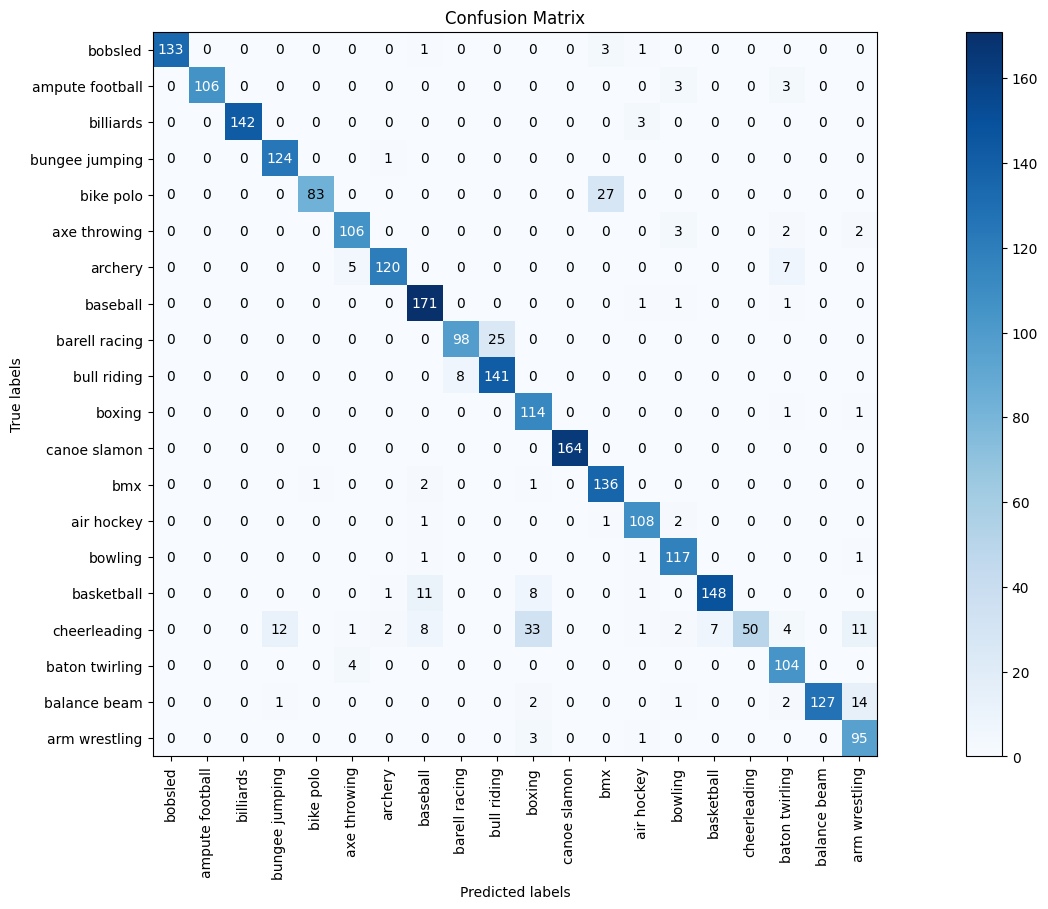

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Tính classification report
report = classification_report(list_truth, list_pred, labels=config.class_new)

# In classification report
print("Classification Report:")
print(report)

# Tính confusion matrix
cm = confusion_matrix(list_truth, list_pred, labels=config.class_new)

# Hiển thị confusion matrix dưới dạng biểu đồ
plt.figure(figsize=(18,9))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(config.class_new))
plt.xticks(tick_marks, config.class_new, rotation=90)
plt.yticks(tick_marks, config.class_new)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()
